# Google drive mount
#### * google colab 사용 시, google drive 내 데이터를 사용하기 위한 절차입니다

In [ ]:
# google drive에 있는 데이터를 사용하기 위해 접근

from google.colab import drive
drive.mount('/content/drive')

# current work path

import os
os.chdir('/content/drive/MyDrive/숨고/오채운님(흡연자 여부)')

Mounted at /content/drive


### Library import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


## Data Load 및 결측치 파악

In [ ]:
train = pd.read_csv("train.csv")
# train set의 흡연상태 중 2(이전에 피웠으나 끊었다)는 제외시켜야 함
train = train[train['SMK_STAT'].isin([0,1])]
print(train.head(5))
train.info()

test = pd.read_csv("test.csv")
print(test.head(5))
test.info()

   ID  SEX  AGE  SIDO  HEIGHT  WEIGHT  WAIST  SIGHT_LEFT  SIGHT_RIGHT  \
0   1    2   35    11     150      65   87.6         1.2          1.2   
1   2    1   55    48     165      70   80.0         0.7          0.9   
2   3    1   40    47     165      60   75.0         1.2          0.9   
3   4    2   25    11     165      45   72.0         1.0          0.9   
4   5    2   75    11     155      65   92.6         0.1          0.7   

   HEAR_LEFT  ...  OLIG_PROTE  CREATININE  SGOT_AST  SGOT_ALT  GAMMA_GTP  \
0        1.0  ...         1.0         0.9      28.0      37.0       46.0   
1        1.0  ...         1.0         1.1      21.0      28.0       31.0   
2        1.0  ...         1.0         1.0      26.0      25.0       21.0   
3        1.0  ...         2.0         0.7      28.0      21.0       13.0   
4        1.0  ...         1.0         1.2      23.0      14.0       88.0   

   DRK_YN  HCHK_OE_INSPEC_YN  CRS_YN  TTR_YN  SMK_STAT  
0       Y                  Y     0.0       Y   

In [ ]:
"""
1) TOT_CHOLE, TRIGLYCERIDE, HDL_CHOLE, LDL_CHOLE, CRS_YN, TTR_YN는 null이 50% 이상이므로 제거 대상
2) 그 외 결측값이 존재하는 변수는 대부분 10% 미만이므로 행 삭제
3) Train set에서 진행한 처리는 Test set도 동일하게 처리
""" 

train = train.drop(['TOT_CHOLE', 'TRIGLYCERIDE', 'HDL_CHOLE', 'LDL_CHOLE', 'CRS_YN', 'TTR_YN'], axis=1)
train = train.dropna().reset_index(drop=True)
train.info()

test = test.drop(['TOT_CHOLE', 'TRIGLYCERIDE', 'HDL_CHOLE', 'LDL_CHOLE', 'CRS_YN', 'TTR_YN'], axis=1)
test = test.dropna().reset_index(drop=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79182 entries, 0 to 79181
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 79182 non-null  int64  
 1   SEX                79182 non-null  int64  
 2   AGE                79182 non-null  int64  
 3   SIDO               79182 non-null  int64  
 4   HEIGHT             79182 non-null  int64  
 5   WEIGHT             79182 non-null  int64  
 6   WAIST              79182 non-null  float64
 7   SIGHT_LEFT         79182 non-null  float64
 8   SIGHT_RIGHT        79182 non-null  float64
 9   HEAR_LEFT          79182 non-null  float64
 10  HEAR_RIGHT         79182 non-null  float64
 11  BP_HIGH            79182 non-null  float64
 12  BP_LWST            79182 non-null  float64
 13  BLDS               79182 non-null  float64
 14  HMG                79182 non-null  float64
 15  OLIG_PROTE         79182 non-null  float64
 16  CREATININE         791

## 연속형 변수 및 범주형 변수 처리

In [ ]:
train_col_categorical = ['SEX','SIDO','OLIG_PROTE','DRK_YN','HCHK_OE_INSPEC_YN','SMK_STAT']
train_cate = train[train_col_categorical].astype('category')
train_num = train.drop(train_col_categorical,axis=1).astype('float')
train_total = pd.concat([train_cate,train_num],axis=1)

test_col_categorical = ['SEX','SIDO','OLIG_PROTE','DRK_YN','HCHK_OE_INSPEC_YN']
test_cate = test[test_col_categorical].astype('category')
test_num = test.drop(test_col_categorical,axis=1).astype('float')
test_total = pd.concat([test_cate,test_num],axis=1)

In [ ]:
# categorical feature -> one hot encoding 진행
encoder = OneHotEncoder(sparse=False)
sex_onehot = encoder.fit_transform(train_total[['SEX']])
print("SEX category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(sex_onehot, columns=['sex_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['SEX']),temp], axis=1)
sex_onehot_test = encoder.transform(test_total[['SEX']])
temp = pd.DataFrame(sex_onehot_test, columns=['sex_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['SEX']),temp], axis=1)

encoder = OneHotEncoder(sparse=False)
sido_onehot = encoder.fit_transform(train_total[['SIDO']])
print("SIDO category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(sido_onehot, columns=['sido_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['SIDO']),temp], axis=1)
sido_onehot_test = encoder.transform(test_total[['SIDO']])
temp = pd.DataFrame(sido_onehot_test, columns=['sido_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['SIDO']),temp], axis=1)

encoder = OneHotEncoder(sparse=False)
olig_prote_onehot = encoder.fit_transform(train_total[['OLIG_PROTE']])
print("OLIG_PROTE category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(olig_prote_onehot, columns=['olig_prote_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['OLIG_PROTE']),temp], axis=1)
olig_prote_onehot_test = encoder.transform(test_total[['OLIG_PROTE']])
temp = pd.DataFrame(olig_prote_onehot_test, columns=['olig_prote_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['OLIG_PROTE']),temp], axis=1)

encoder = OneHotEncoder(sparse=False)
drk_yn_onehot = encoder.fit_transform(train_total[['DRK_YN']])
print("DRK_YN category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(drk_yn_onehot, columns=['drk_yn_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['DRK_YN']),temp], axis=1)
drk_yn_onehot_test = encoder.transform(test_total[['DRK_YN']])
temp = pd.DataFrame(drk_yn_onehot_test, columns=['drk_yn_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['DRK_YN']),temp], axis=1)

encoder = OneHotEncoder(sparse=False)
hchk_oe_inspec_yn_onehot = encoder.fit_transform(train_total[['HCHK_OE_INSPEC_YN']])
print("HCHK_OE_INSPEC_YN category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(hchk_oe_inspec_yn_onehot, columns=['hchk_oe_inspec_yn_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['HCHK_OE_INSPEC_YN']),temp], axis=1)
hchk_oe_inspec_yn_onehot_test = encoder.transform(test_total[['HCHK_OE_INSPEC_YN']])
temp = pd.DataFrame(hchk_oe_inspec_yn_onehot_test, columns=['hchk_oe_inspec_yn_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['HCHK_OE_INSPEC_YN']),temp], axis=1)

# ID는 필요 없으므로 제거
train_id = test_total['ID']
train_total = train_total.drop(['ID'], axis=1)
test_id = test_total['ID']
test_total = test_total.drop(['ID'], axis=1)

SEX category :  [1 2] 

SIDO category :  [11 26 27 28 29 30 31 36 41 42 43 44 45 46 47 48 50] 

OLIG_PROTE category :  [1. 2. 3. 4. 5. 6.] 

DRK_YN category :  ['N' 'Y'] 

HCHK_OE_INSPEC_YN category :  ['N' 'Y'] 



In [ ]:
train_total.head(5)

,SMK_STAT,AGE,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,...,olig_prote_1.0,olig_prote_2.0,olig_prote_3.0,olig_prote_4.0,olig_prote_5.0,olig_prote_6.0,drk_yn_N,drk_yn_Y,hchk_oe_inspec_yn_N,hchk_oe_inspec_yn_Y
0,0,35.0,150.0,65.0,87.6,1.2,1.2,1.0,1.0,115.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,55.0,165.0,70.0,80.0,0.7,0.9,1.0,1.0,128.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,40.0,165.0,60.0,75.0,1.2,0.9,1.0,1.0,134.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,25.0,165.0,45.0,72.0,1.0,0.9,1.0,1.0,104.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0,75.0,155.0,65.0,92.6,0.1,0.7,1.0,1.0,134.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## Model train & test

In [ ]:
# train/test split
from sklearn.model_selection import train_test_split

X = train_total.drop(['SMK_STAT'],axis=1)
y = train_total['SMK_STAT']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=123)

print(f"train_x size : {x_train.shape}")
print(f"train_y size : {y_train.shape}")
print(f"x_test size : {x_test.shape}")
print(f"y_test size : {y_test.shape}")


train_x size : (71263, 45)
train_y size : (71263,)
x_test size : (7919, 45)
y_test size : (7919,)


In [ ]:
# model 학습 with (xgboost, randomforest)
# xgboost/randomforest는 모두 앙상블 기법 중 각각 부스팅/배깅 기법을 대표하는 알고리즘이며, 
# 둘 모두 overfitting에 강하다는 장점이 있음

# cross_validation을 통한 하이퍼 파라미터 최적화 진행(Kfold with K=5)
n = range(10,100,10)

rf_scores = []
xg_scores = []
for k in n:
    print(f"Current tree : {k}")
    rf_model = RandomForestClassifier(n_estimators = k, n_jobs=-1)
    xg_model = XGBClassifier(n_estimators = k, n_jobs=-1)
    rf_scores.append(cross_val_score(rf_model, x_train, y_train, scoring='f1', cv=5, n_jobs=-1).mean())
    xg_scores.append(cross_val_score(xg_model, x_train, y_train, scoring='f1', cv=5, n_jobs=-1).mean())
    print('finished')

Current tree : 10
finished
Current tree : 20
finished
Current tree : 30
finished
Current tree : 40
finished
Current tree : 50
finished
Current tree : 60
finished
Current tree : 70
finished
Current tree : 80
finished
Current tree : 90
finished


<Cross validation result>
Random forest val_score : [0.593365036680299, 0.6327386636562184, 0.6463727606040568, 0.6512290630544618, 0.6556388186180975, 0.6587691951163035, 0.6617248891454548, 0.6603888045113623, 0.662455273830797]
Xgboost val_score : [0.6496901142992441, 0.6648306875670392, 0.6707878668902033, 0.6733847091601379, 0.6743187581131841, 0.6762388193331963, 0.6770292117131251, 0.6771975314987618, 0.6767494909862408]


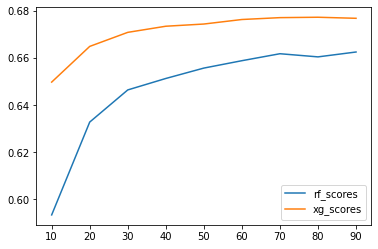

In [ ]:
import matplotlib.pyplot as plt

print("<Cross validation result>")
print(f"Random forest val_score : {rf_scores}")
print(f"Xgboost val_score : {xg_scores}")

plt.plot(range(10,100,10), rf_scores)
plt.plot(range(10,100,10), xg_scores)
plt.legend(['rf_scores', 'xg_scores'])
plt.show()

* xgboost가 일반적으로 성능이 더 좋으며, tree 80인 경우의 성능이 가장 좋음

In [ ]:
# 최적의 hyper-param으로 재학습
xg_model = XGBClassifier(n_neighbors=80, n_jobs=-1)
xg_model.fit(x_train, y_train)

# test set 적용 결과
print("Test F1score of xgboost : ",round(f1_score(y_test,xg_model.predict(x_test)),3))

Test F1score of xgboost :  0.68


In [ ]:
# 실제 test set에 대한 예측
test_total_predict = pd.DataFrame(xg_model.predict(test_total))
test_total_predict.columns = ['SMK_STAT']
test_result = pd.concat([test_id, test_total, test_total_predict],axis=1)
test_result

,ID,AGE,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,...,olig_prote_2.0,olig_prote_3.0,olig_prote_4.0,olig_prote_5.0,olig_prote_6.0,drk_yn_N,drk_yn_Y,hchk_oe_inspec_yn_N,hchk_oe_inspec_yn_Y,SMK_STAT
0,100001.0,40.0,155.0,45.0,65.0,0.9,1.2,1.0,1.0,125.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
1,100002.0,65.0,155.0,70.0,91.0,0.8,0.7,1.0,1.0,139.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,100003.0,60.0,155.0,50.0,77.5,0.5,0.6,1.0,1.0,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
3,100004.0,40.0,165.0,65.0,79.0,1.0,1.0,1.0,1.0,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
4,100005.0,25.0,160.0,50.0,67.0,1.2,1.0,1.0,1.0,109.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98811,199996.0,30.0,175.0,65.0,82.0,1.5,1.5,1.0,1.0,132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
98812,199997.0,55.0,160.0,75.0,89.0,1.0,0.9,1.0,1.0,132.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
98813,199998.0,45.0,150.0,55.0,66.0,0.9,0.9,1.0,1.0,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
98814,199999.0,50.0,170.0,70.0,82.4,1.0,1.0,1.0,1.0,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
